## DE with voom limma
* rsem expected counts are used

In [1]:
require("edgeR")
require("limma")
library(readr)
require(tximport)
DATA = '../data/'

Loading required package: edgeR
Loading required package: limma
Loading required package: tximport


In [2]:
# from https://github.com/mikelove/tximport/blob/master/vignettes/tximport.md#rsem
labels = c('g1eer4.1', 'g1eer4.2', 'mel.1', 'mel.2', 'eryth.1', 'eryth.2')
files <- file.path(DATA, "countsForTximport", paste0(labels, ".tsv"))
names(files) <- labels
txi.rsem <- tximport(files, type = "rsem", reader = read_tsv)

reading in files
1 Parsed with column specification:
cols(
  gene_id = col_character(),
  `transcript_id(s)` = col_character(),
  length = col_double(),
  effective_length = col_double(),
  expected_count = col_double(),
  TPM = col_double(),
  FPKM = col_double(),
  posterior_mean_count = col_double(),
  posterior_standard_deviation_of_count = col_double(),
  pme_TPM = col_double(),
  pme_FPKM = col_double(),
  TPM_ci_lower_bound = col_double(),
  TPM_ci_upper_bound = col_double(),
  FPKM_ci_lower_bound = col_double(),
  FPKM_ci_upper_bound = col_double()
)
2 Parsed with column specification:
cols(
  gene_id = col_character(),
  `transcript_id(s)` = col_character(),
  length = col_double(),
  effective_length = col_double(),
  expected_count = col_double(),
  TPM = col_double(),
  FPKM = col_double(),
  posterior_mean_count = col_double(),
  posterior_standard_deviation_of_count = col_double(),
  pme_TPM = col_double(),
  pme_FPKM = col_double(),
  TPM_ci_lower_bound = col_double(),
 

In [30]:
# rm rows with all low expressed genes
# 50 and 10 are pretty good
# gtr 10 in at least two samples
# isexpr <- rowSums(cpm(x) > 10) >= 2
# 5 and 2 puts them very close
isexpr <- rowSums(txi.rsem$counts > 35) > 1
useM = txi.rsem$counts[isexpr,]

#flag = apply(txi.rsem$counts, 1, max)>5
#useMpre = txi.rsem$counts[flag,]
#flag = apply(useMpre, 1, min)>2
#useM = useMpre[flag,]

In [31]:
head(txi.rsem$counts)

,g1eer4.1,g1eer4.2,mel.1,mel.2,eryth.1,eryth.2
Gnai3,7763,6817,8831,11861,86,53
Pbsn,0,0,0,0,0,0
Cdc45,1070,1089,4926,6871,780,752
H19,0,0,1,1,1920,1519
Scml2,52,40,1,0,6,11
Apoh,0,0,1,0,0,3


In [32]:
dim(txi.rsem$counts)

[1] 30433     6

In [33]:
log(35,2)

[1] 5.129283

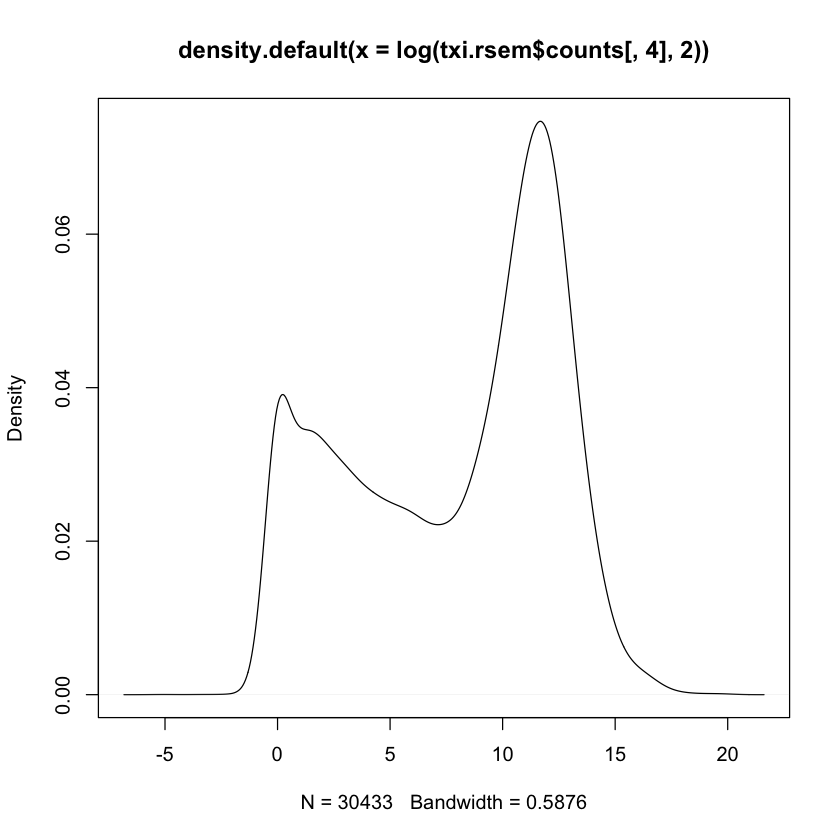

In [34]:
# use log(x,2) > 5
plot( density(log(txi.rsem$counts[, 4], 2) ) )

In [35]:
dim(useM)

[1] 12040     6

In [36]:
y <- DGEList(counts=as.matrix(useM), genes=rownames(useM))
y <- calcNormFactors(y)

In [37]:
# condition = factor(rep(c("A", "B"), each = 3)))
m=c('g1eer4','g1eer4', 'mel', 'mel','eryth', 'eryth')
design <- model.matrix(~factor(m))
print(design)

  (Intercept) factor(m)g1eer4 factor(m)mel
1           1               1            0
2           1               1            0
3           1               0            1
4           1               0            1
5           1               0            0
6           1               0            0
attr(,"assign")
[1] 0 1 1
attr(,"contrasts")
attr(,"contrasts")$`factor(m)`
[1] "contr.treatment"



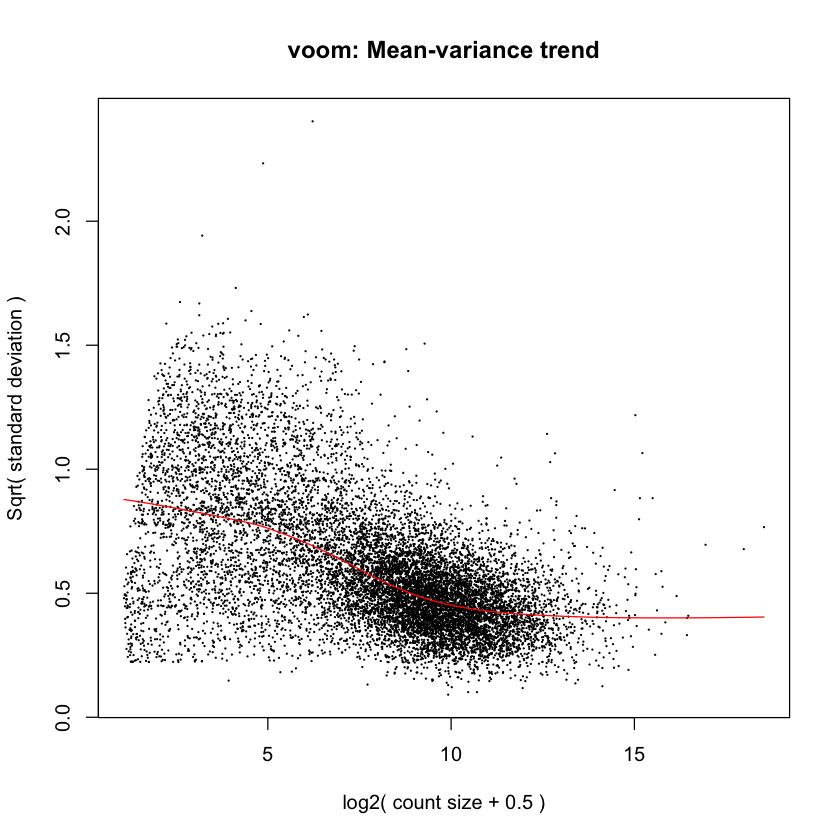

In [38]:
#targets = data.frame()
#colnames()
#design <- model.matrix(~as.factor(labels))
#print(design)
v <- voom(y, design, plot=TRUE);
voomData <- v$E

In [39]:
#Run linear fit and Create the contrast
design <- model.matrix(~0+factor(m))
colnames(design) <- c('g1eer4', 'mel', 'eryth')
fit <- lmFit(voomData, design)

In [40]:
contrast.matrix <- makeContrasts(g1eVsOther="g1eer4-mel-eryth",
                                 melVsOther="mel-g1eer4-eryth",
                                 erythVsOther="eryth-g1eer4-mel",
                                 g1eVsMel="g1eer4-mel",
                                 levels=design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

#Okay now combine all into one result data frame
#myComps <- colnames(fit2$contrasts);

In [41]:
myComps <- colnames(fit2$contrasts)
output <- topTable(fit2, number=60000)
genOutput <- output[,c(c(1:length(myComps)), grep("P.Value", colnames(output)))]
colnames(genOutput)[1:length(myComps)] <- myComps;
tmpOut <- topTable(fit2, number=60000, 1)[,c("logFC", "P.Value", "adj.P.Val")];
colnames(tmpOut) <- paste(myComps[1], colnames(tmpOut), sep="_");
IndComp <- tmpOut;

    for(i in 2:length(myComps))
    {
    tmpOut <- topTable(fit2, number=60000, i)[,c("logFC", "P.Value", "adj.P.Val")];
    tmpOut <- tmpOut[rownames(IndComp),];
    colnames(tmpOut) <- paste(myComps[i], colnames(tmpOut), sep="_");
    IndComp <- cbind(IndComp, tmpOut);
    }

AllResult <- list(genOutput, IndComp, voomData, design, myComps);

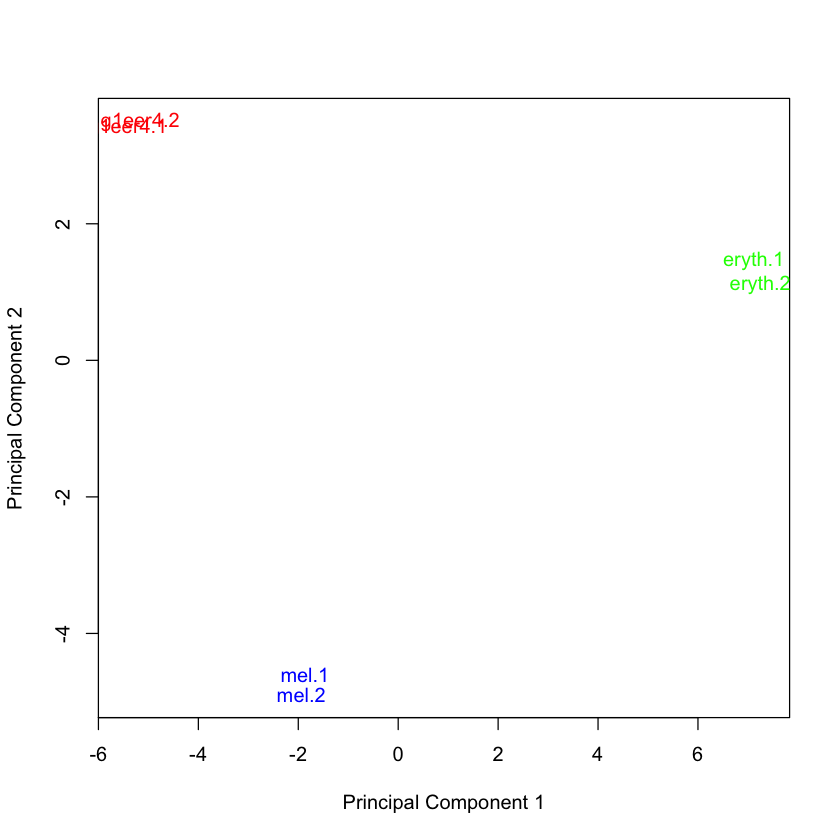

In [42]:
mycol=c("red", "red", "blue", "blue", "green", "green", 'purple', 'purple', 'orange', 'orange')
plotMDS(v, top=50, labels=labels, col=mycol, gene.selection="common")

In [43]:
names(AllResult) <- c("effectPval", "fullResult", "voomMatrix", "design", "comparison")

In [59]:
l = AllResult$fullResult[ AllResult$fullResult['g1eVsOther_adj.P.Val']<0.05
                          & abs(AllResult$fullResult['g1eVsOther_logFC'])>10, ]
dim(l)

[1] 590  12

In [60]:
head(l)

,g1eVsOther_logFC,g1eVsOther_P.Value,g1eVsOther_adj.P.Val,melVsOther_logFC,melVsOther_P.Value,melVsOther_adj.P.Val,erythVsOther_logFC,erythVsOther_P.Value,erythVsOther_adj.P.Val,g1eVsMel_logFC,g1eVsMel_P.Value,g1eVsMel_adj.P.Val
Gm6311,-17.96005,6.444429e-09,1.214715e-05,5.639525,1.591962e-06,1.247448e-05,3.267870,2.095410e-05,6.327748e-05,-11.799788,1.814305e-08,2.118307e-05
Hist2h3c2-ps,-22.07039,9.708903e-09,1.214715e-05,2.831135,1.593182e-04,3.255033e-04,6.076259,4.460704e-06,2.249974e-05,-12.450764,5.645428e-08,2.118307e-05
Snora73b,-18.63555,1.127537e-08,1.214715e-05,-4.371625,1.101764e-05,3.918829e-05,13.279019,5.660767e-08,8.074063e-06,-7.131965,4.150737e-07,2.727652e-05
mt-Co3,-21.59622,1.443154e-08,1.214715e-05,3.910049,4.738675e-05,1.178064e-04,4.859841,1.710200e-05,5.466966e-05,-12.753134,6.749016e-08,2.118307e-05
Runx1t1,20.30978,1.748263e-08,1.214715e-05,-3.992899,3.892310e-05,1.009987e-04,-8.044094,1.429908e-06,1.269624e-05,12.151341,7.681608e-08,2.118307e-05
Dnajb3,19.76820,1.852369e-08,1.214715e-05,-3.451315,7.166556e-05,1.649815e-04,-7.502510,1.854393e-06,1.426638e-05,11.609756,8.890476e-08,2.118307e-05


In [56]:
l = AllResult$fullResult[ AllResult$fullResult['melVsOther_adj.P.Val']<0.05
                          & abs(AllResult$fullResult['melVsOther_logFC'])>10, ]
dim(l)

[1] 741  12

In [57]:
l = AllResult$fullResult[ AllResult$fullResult['erythVsOther_adj.P.Val']<0.05
                          & abs(AllResult$fullResult['erythVsOther_logFC'])>10, ]
dim(l)

[1] 729  12

In [58]:
head(l)

,g1eVsOther_logFC,g1eVsOther_P.Value,g1eVsOther_adj.P.Val,melVsOther_logFC,melVsOther_P.Value,melVsOther_adj.P.Val,erythVsOther_logFC,erythVsOther_P.Value,erythVsOther_adj.P.Val,g1eVsMel_logFC,g1eVsMel_P.Value,g1eVsMel_adj.P.Val
Snora73b,-18.635554,1.127537e-08,1.214715e-05,-4.371625,1.101764e-05,3.918829e-05,13.27902,5.660767e-08,8.074063e-06,-7.131965,4.150737e-07,2.727652e-05
mt-Co1,-13.792976,6.632197e-08,1.214715e-05,-7.957280,9.066014e-07,9.950301e-06,-11.81477,1.385374e-07,8.074063e-06,-2.917848,3.966918e-05,1.957446e-04
Rpl4,-11.062863,1.894860e-07,1.214715e-05,-7.155204,1.501534e-06,1.214934e-05,-10.63783,2.282919e-07,8.074063e-06,-1.953829,2.540808e-04,6.982728e-04
mt-Cytb,-10.350888,1.936350e-07,1.214715e-05,-4.340134,1.191393e-05,4.142180e-05,-14.75102,3.588478e-08,8.074063e-06,-3.005377,2.585092e-05,1.496813e-04
Snora74a,-10.005297,1.969071e-07,1.214715e-05,-2.771880,8.428861e-05,1.893702e-04,11.67927,9.433051e-08,8.074063e-06,-3.616708,9.375721e-06,8.623658e-05
Rbm25,-7.795407,3.109062e-07,1.214715e-05,-3.844077,8.870111e-06,3.370026e-05,-10.49578,7.554323e-08,8.074063e-06,-1.975665,7.766281e-05,3.059433e-04
